In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
try:
    df = pd.read_csv('flood.csv')
except FileNotFoundError:
    print("Error: 'flood.csv' not found. Please make sure the file is in the correct directory.")
    exit()

# Display basic information and the first few rows
print("--- Dataset Info ---")
df.info()
print("\n--- First 5 Rows of the Dataset ---")
print(df.head())
print("\n--- Basic Statistical Summary ---")
print(df.describe(include='all'))
print("\n--- Missing Values Per Column ---")
print(df.isnull().sum())

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  50000 non-null  int64  
 1

In [2]:
# --- Define target variable and features ---
TARGET_COLUMN_NAME = 'Flood_Label'

if TARGET_COLUMN_NAME not in df.columns:
    print(f"Error: Target column '{TARGET_COLUMN_NAME}' not found in the DataFrame.")
    print(f"Available columns are: {df.columns.tolist()}")
    print("Please update TARGET_COLUMN_NAME in the script.")


X = df.drop(TARGET_COLUMN_NAME, axis=1)
y = df[TARGET_COLUMN_NAME]

print("\n--- Features (X) Head ---")
print(X.head())
print("\n--- Target (y) Head ---")
print(y.head())
print("\nTarget value counts:")
print(y.value_counts())

Error: Target column 'Flood_Label' not found in the DataFrame.
Available columns are: ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors', 'FloodProbability']
Please update TARGET_COLUMN_NAME in the script.

--- Features (X) Head ---
   MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 3                   8                6              6   
1                 8                   4                5              7   
2                 3                  10                4              1   
3                 4                   4                2              7   
4                 3                   7          

In [11]:
# --- Identify Numerical and Categorical Features ---
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"\nNumerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

# --- Create Preprocessing Pipelines ---
# For Numerical Features: Only scaling is needed as there are no missing values
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# For Categorical Features: Only one-hot encoding (if any categorical features exist)
if categorical_features:
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
else:
    categorical_pipeline = None


# --- Create Column Transformer to Apply Pipelines ---
transformers_list = []
if numerical_features:
    transformers_list.append(('num', numerical_pipeline, numerical_features))
# Only add categorical transformer if there are categorical features AND the pipeline is defined
if categorical_features and categorical_pipeline:
    transformers_list.append(('cat', categorical_pipeline, categorical_features))

if not X.empty and not transformers_list and numerical_features and not categorical_features:
    # This case handles if X only has numerical features and we just want to scale them
    print("Only numerical features detected. Applying StandardScaler directly.")
    scaler = StandardScaler()
    X_processed = scaler.fit_transform(X)
    processed_feature_names = X.columns.tolist()
elif transformers_list:
    preprocessor = ColumnTransformer(transformers=transformers_list, remainder='passthrough')
    X_processed = preprocessor.fit_transform(X)
    # Get feature names after preprocessing
    try:
        processed_feature_names = []
        if numerical_features:
            processed_feature_names.extend(numerical_features) # Scaler doesn't change names
        if categorical_features and categorical_pipeline: # Check if 'cat' transformer exists
            if 'cat' in preprocessor.named_transformers_:
                ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
                processed_feature_names.extend(ohe_feature_names)
            else: # Should not happen if logic is correct but as a safeguard
                print("Warning: Categorical transformer 'cat' not found in preprocessor despite categorical features being present.")

        # Handle 'passthrough' columns feature names if any were defined and captured
        if 'remainder' in preprocessor.named_transformers_ and hasattr(preprocessor.named_transformers_['remainder'], 'get_feature_names_out'):
             passthrough_features = preprocessor.named_transformers_['remainder'].get_feature_names_out()
             processed_feature_names.extend(passthrough_features)

    except Exception as e:
        print(f"Could not fully retrieve all processed feature names: {e}")
        # Fallback: generate generic names if specific names can't be derived
        num_output_features = X_processed.shape[1]
        processed_feature_names = [f"feature_{i}" for i in range(num_output_features)]
else:
    print("Warning: No features to process or X is empty. X_processed will be an empty array or X as is.")
    X_processed = X.to_numpy() # Fallback
    processed_feature_names = X.columns.tolist()


print(f"\nShape of X_processed: {X_processed.shape}")
if processed_feature_names:
    print(f"Number of features after processing: {len(processed_feature_names)}")

# Convert y to numpy array (target variable for regression is continuous)
y_processed = y.astype(np.float32).to_numpy() # Ensure y is float for regression

print("\n--- Preprocessing Complete ---")
# print("Head of X_processed (first 5 rows, first 5 features if available):")
# if X_processed.shape[1] > 0 :
# print(X_processed[:5, :min(5, X_processed.shape[1])])
# else:
# print("X_processed is empty or has no features.")


Numerical Features: ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors']
Categorical Features: []

Shape of X_processed: (50000, 20)
Number of features after processing: 20

--- Preprocessing Complete ---


In [12]:
# --- Split Data ---
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y_processed, test_size=0.20, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42 # 0.25 * 0.80 = 0.20
)

print(f"\nShape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"Shape of X_test:  {X_test.shape}, y_test:  {y_test.shape}")

print("\nSample of y_train (target values):")
print(y_train[:5])


Shape of X_train: (30000, 20), y_train: (30000,)
Shape of X_val:   (10000, 20), y_val:   (10000,)
Shape of X_test:  (10000, 20), y_test:  (10000,)

Sample of y_train (target values):
[0.51  0.495 0.39  0.495 0.495]


In [13]:
# --- Define MLP Model Architecture for Regression ---
input_features = X_train.shape[1]
print(f"\nNumber of input features for MLP: {input_features}")

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_features,), kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid') # Outputting a single continuous value (probability)
                                        # Sigmoid is good here because probability is bounded (0 to 1).
])

model.summary()


Number of input features for MLP: 20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# --- Compile the Model for Regression ---
METRICS_REGRESSION = [
    keras.metrics.MeanSquaredError(name='mse'),
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.RootMeanSquaredError(name='rmse')
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='mean_squared_error',
    metrics=METRICS_REGRESSION
)

print("\n--- Model Compilation Complete for Regression ---")


--- Model Compilation Complete for Regression ---


In [15]:
# --- Train the Model ---
early_stopping_reg = keras.callbacks.EarlyStopping(
    monitor='val_loss',   # Monitor validation loss for regression
    patience=25,
    verbose=1,
    mode='min',          # For loss, we want to minimize it
    restore_best_weights=True
)

reduce_lr_reg = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=0.00001,
    mode='min', # Minimize loss
    verbose=1
)

EPOCHS = 200
BATCH_SIZE = 32

print(f"\n--- Starting Model Training for Regression (Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}) ---")

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_reg, reduce_lr_reg],
    verbose=1
)

print("\n--- Model Training Complete ---")


--- Starting Model Training for Regression (Epochs: 200, Batch Size: 32) ---
Epoch 1/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0796 - mae: 0.0389 - mse: 0.0031 - rmse: 0.0531 - val_loss: 0.0015 - val_mae: 0.0090 - val_mse: 2.2327e-04 - val_rmse: 0.0149 - learning_rate: 5.0000e-04
Epoch 2/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0013 - mae: 0.0145 - mse: 3.9327e-04 - rmse: 0.0198 - val_loss: 7.9613e-04 - val_mae: 0.0080 - val_mse: 1.5602e-04 - val_rmse: 0.0125 - learning_rate: 5.0000e-04
Epoch 3/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.7337e-04 - mae: 0.0139 - mse: 3.4156e-04 - rmse: 0.0185 - val_loss: 7.1044e-04 - val_mae: 0.0069 - val_mse: 1.1565e-04 - val_rmse: 0.0108 - learning_rate: 5.0000e-04
Epoch 4/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.0513e-04 - mae: 0.0138 - mse: 3.3499e-04 - rmse: 0.0183 - val_loss: 6.5966e-04 - val_mae: 0.0070 - val_mse: 1.2177e-04 - val_rmse: 0.0110 - learning_rate: 5.0000e-04
Epoch 5/200
938/938 ━━


--- Evaluating Regression Model on Test Set ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7830e-04 - mae: 0.0028 - mse: 7.3060e-05 - rmse: 0.0085

Test Set Evaluation Results (from model.evaluate()):
loss: 0.0003
compile_metrics: 0.0001
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Scikit-learn Test MSE: 0.0001
Scikit-learn Test MAE: 0.0029
Scikit-learn Test R-squared: 0.9697


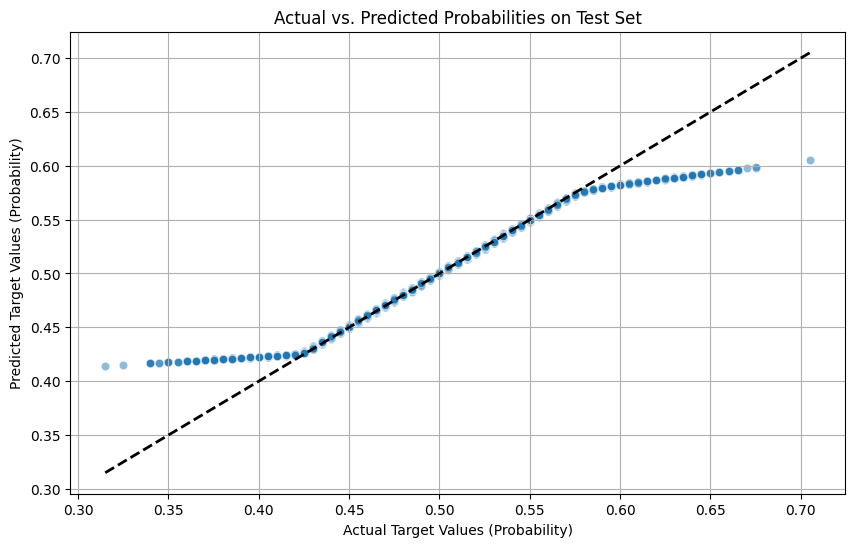

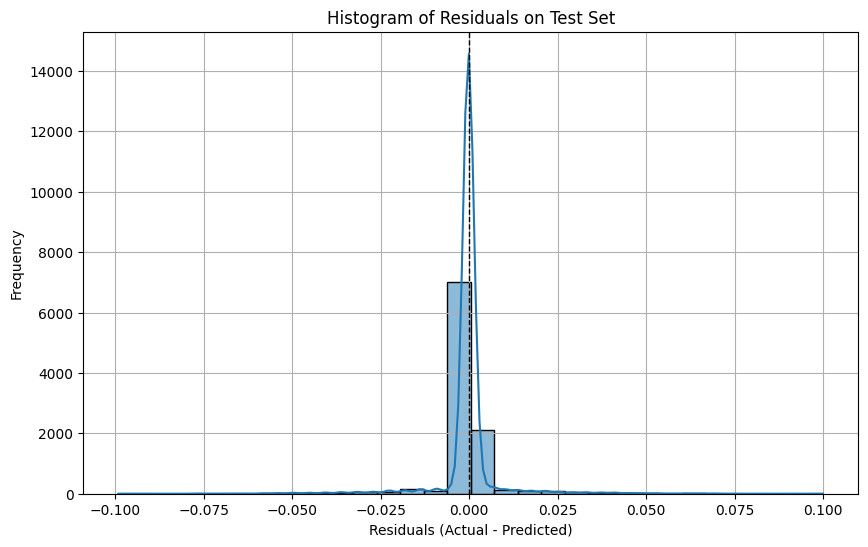

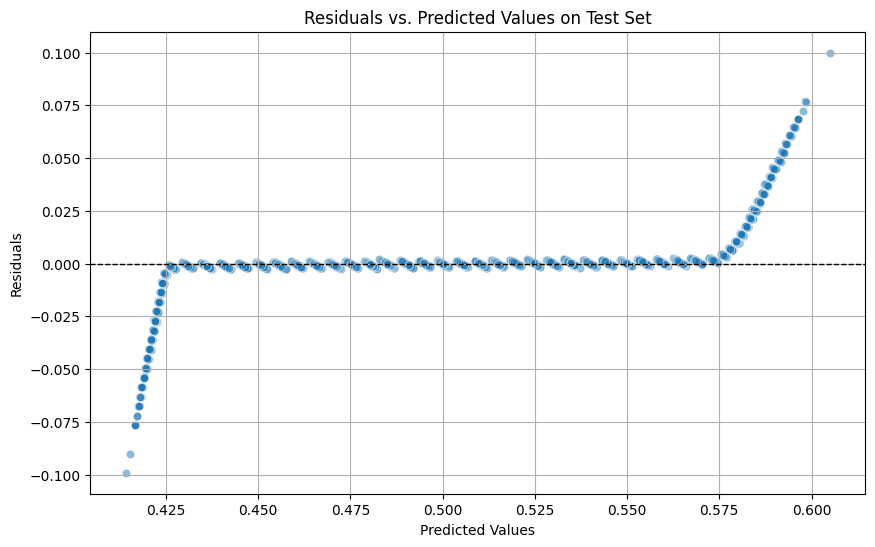

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Evaluate the Model on the Test Set ---
print("\n--- Evaluating Regression Model on Test Set ---")
results = model.evaluate(X_test, y_test, verbose=1)

print("\nTest Set Evaluation Results (from model.evaluate()):")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Get predictions
y_pred_test = model.predict(X_test).ravel()

# Calculate additional regression metrics using scikit-learn
mse_sk = mean_squared_error(y_test, y_pred_test)
mae_sk = mean_absolute_error(y_test, y_pred_test)
r2_sk = r2_score(y_test, y_pred_test)

print(f"\nScikit-learn Test MSE: {mse_sk:.4f}")
print(f"Scikit-learn Test MAE: {mae_sk:.4f}")
print(f"Scikit-learn Test R-squared: {r2_sk:.4f}")

# --- Visualize Predictions vs Actuals ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, edgecolors='w', linewidth=0.5)
plt.plot([min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())],
         [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())],
         'k--', lw=2)
plt.xlabel("Actual Target Values (Probability)")
plt.ylabel("Predicted Target Values (Probability)")
plt.title("Actual vs. Predicted Probabilities on Test Set")
plt.grid(True)
plt.show()

# --- Visualize Residuals ---
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals on Test Set")
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5, edgecolors='w', linewidth=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values on Test Set")
plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
plt.grid(True)
plt.show()

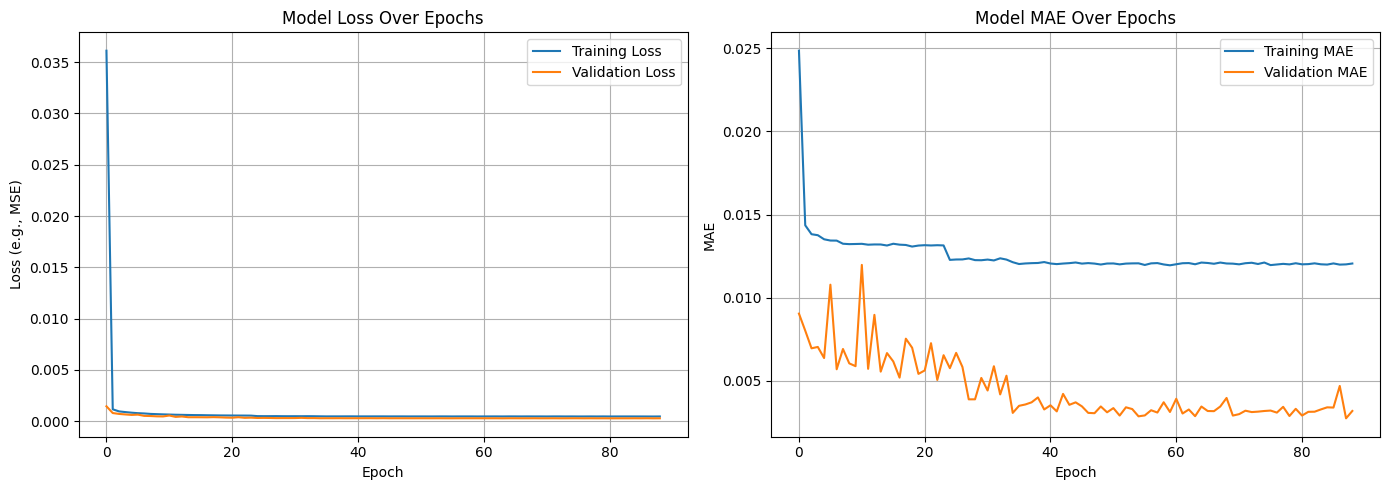

In [17]:
# --- Plot Learning Curves (Loss and a Key Metric like MAE) ---
if history is not None:
    history_df = pd.DataFrame(history.history)

    plt.figure(figsize=(14, 5))

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_df['loss'], label='Training Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss (e.g., MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plot Training & Validation MAE
    metric_to_plot = 'mae'
    val_metric_to_plot = 'val_mae'
    if 'mae' not in history_df.columns and 'mean_absolute_error' in history_df.columns :
        metric_to_plot = 'mean_absolute_error'
        val_metric_to_plot = 'val_mean_absolute_error'
    elif 'mse' in history_df.columns and 'mae' not in history_df.columns :
        metric_to_plot = 'mse'
        val_metric_to_plot = 'val_mse'


    if metric_to_plot in history_df.columns and val_metric_to_plot in history_df.columns:
        plt.subplot(1, 2, 2)
        plt.plot(history_df[metric_to_plot], label=f'Training {metric_to_plot.upper()}')
        plt.plot(history_df[val_metric_to_plot], label=f'Validation {metric_to_plot.upper()}')
        plt.title(f'Model {metric_to_plot.upper()} Over Epochs')
        plt.ylabel(metric_to_plot.upper())
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.grid(True)
    else:
        print(f"Warning: Could not plot training/validation for '{metric_to_plot}'. Check history keys: {history_df.columns}")


    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for plotting.")

In [ ]:
if 'df' not in locals():
    print("INFO: 'df' not found, creating a dummy 'df' for demonstration.")
    dummy_data_for_df = {
        'MonsoonIntensity': np.random.rand(100) * 10,
        'TopographyDrainage': np.random.rand(100) * 10,
        'RiverManagement': np.random.rand(100) * 10,
        'PoliticalFactors': np.random.rand(100) * 10,
        'Flood_Label': np.random.rand(100)
    }
    df = pd.DataFrame(dummy_data_for_df)
    TARGET_COLUMN_NAME = 'Flood_Label'
    print("Dummy 'df' created. You should use your actual 'df'.")

if 'X_original_full' not in locals():
    if TARGET_COLUMN_NAME in df.columns:
        X_original_full = df.drop(TARGET_COLUMN_NAME, axis=1)
        print(f"X_original_full created from df. Shape: {X_original_full.shape}")
    else:
        print(f"Error: Target column '{TARGET_COLUMN_NAME}' not found in df to create X_original_full.")
        if 'X' in locals() and isinstance(X, pd.DataFrame):
             X_original_full = X
             print(f"Using existing X as X_original_full. Shape: {X_original_full.shape}")
        else:
             print("Cannot define X_original_full. Exiting.")
             exit()


if 'model' not in locals():
    print("Error: Trained 'model' is not available. Please train or load it first.")
    print("INFO: Creating a dummy 'model' for demonstration. Use your actual trained model.")
    input_features_dummy = X_original_full.shape[1]
    if 'preprocessor' not in locals():
         if not X_original_full.select_dtypes(exclude=np.number).columns.tolist():
            input_features_dummy = X_original_full.shape[1]
         else:
            print("Error: Cannot determine input features for dummy model without a preprocessor if categorical features exist.")
            exit()
    else:
        try:
            dummy_X_processed_shape_test = preprocessor.transform(X_original_full.head(1)).shape[1]
            input_features_dummy = dummy_X_processed_shape_test
        except Exception as e:
            print(f"INFO: Could not use preprocessor for dummy model shape ({e}). Using raw feature count.")
            input_features_dummy = X_original_full.shape[1]


    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_features_dummy,)),
        layers.Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam', loss='mean_squared_error')
    print("Dummy 'model' created.")


if 'preprocessor' not in locals():
    print("Error: Fitted 'preprocessor' (ColumnTransformer or Scaler) is not available.")
    print("INFO: Creating a dummy 'preprocessor' for demonstration. Use your actual fitted preprocessor.")
    if not X_original_full.select_dtypes(exclude=np.number).columns.tolist(): # if all numeric
        preprocessor = StandardScaler()
        preprocessor.fit(X_original_full) # Fitting on dummy data, not ideal
        print("Dummy 'StandardScaler' preprocessor created and fitted on X_original_full (not recommended for real use).")
    else:
        print("Cannot create a meaningful dummy preprocessor if categorical features exist. Please ensure your actual preprocessor is loaded.")
        exit()

print("\n--- Ensuring all necessary variables are conceptually available ---")

In [22]:
# Ensure X_original_full is defined from the previous cell.
if 'X_original_full' not in locals() or X_original_full.empty:
    print("Error: X_original_full (original features from flood.csv) is not defined or is empty.")
else:
    print(f"Preprocessing X_original_full with shape: {X_original_full.shape}")
    try:
        X_full_processed = preprocessor.transform(X_original_full)
        print(f"Shape of X_full_processed: {X_full_processed.shape}")
    except Exception as e:
        print(f"Error during preprocessing X_original_full: {e}")
        print("Make sure 'preprocessor' was fitted correctly on data with the same columns as X_original_full.")
        print("INFO: Using X_original_full.to_numpy() as X_full_processed due to error. Predictions will be incorrect.")
        X_full_processed = X_original_full.to_numpy()


print("\n--- Full dataset preprocessed for prediction ---")

Preprocessing X_original_full with shape: (50000, 20)
Shape of X_full_processed: (50000, 20)

--- Full dataset preprocessed for prediction ---


In [23]:
# Ensure model and X_full_processed are available
if 'model' in locals() and 'X_full_processed' in locals() and X_full_processed.shape[0] > 0:
    print(f"Making predictions on X_full_processed with shape: {X_full_processed.shape}")
    predicted_probabilities_full = model.predict(X_full_processed).ravel()
    print(f"Shape of predicted_probabilities_full: {predicted_probabilities_full.shape}")
    print("Sample predicted probabilities (first 10):")
    print(predicted_probabilities_full[:10])

    # Create a new DataFrame with original features and their predicted probabilities
    df_with_predictions = X_original_full.copy()
    if len(predicted_probabilities_full) == len(df_with_predictions):
        df_with_predictions['Predicted_Flood_Probability'] = predicted_probabilities_full
    else:
        print(f"Warning: Length of predictions ({len(predicted_probabilities_full)}) does not match "
              f"length of X_original_full ({len(df_with_predictions)}). Cannot reliably add predictions column.")
else:
    print("Error: 'model' or 'X_full_processed' is not available or empty. Cannot make predictions.")
    if 'df_with_predictions' not in locals() and 'X_original_full' in locals():
        print("INFO: Creating dummy 'df_with_predictions' as predictions could not be made.")
        df_with_predictions = X_original_full.copy()
        df_with_predictions['Predicted_Flood_Probability'] = np.random.rand(len(df_with_predictions))


print("\n--- Predictions made on the full dataset ---")
if 'df_with_predictions' in locals():
    print("Head of DataFrame with predictions:")
    print(df_with_predictions.head())

Making predictions on X_full_processed with shape: (50000, 20)
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Shape of predicted_probabilities_full: (50000,)
Sample predicted probabilities (first 10):
[0.45119485 0.47442177 0.515267   0.52005625 0.47606775 0.47142527
 0.5692829  0.57829964 0.57646155 0.55498254]

--- Predictions made on the full dataset ---
Head of DataFrame with predictions:
   MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 3                   8                6              6   
1                 8                   4                5              7   
2                 3                  10                4              1   
3                 4                   4                2              7   
4                 3                   7                5              2   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             4              4            6          2                      

In [30]:
if 'df_with_predictions' in locals() and 'Predicted_Flood_Probability' in df_with_predictions.columns:
    # Define thresholds
    HIGH_PROB_THRESHOLD = 0.55
    LOW_PROB_THRESHOLD = 0.45

    # Create flood event labels
    df_with_predictions['New_Binary_Flood_Label'] = -1 # Placeholder

    # Label flood events (Class 1)
    df_with_predictions.loc[df_with_predictions['Predicted_Flood_Probability'] > HIGH_PROB_THRESHOLD, 'New_Binary_Flood_Label'] = 1

    # Label non-flood events (Class 0)
    df_with_predictions.loc[df_with_predictions['Predicted_Flood_Probability'] < LOW_PROB_THRESHOLD, 'New_Binary_Flood_Label'] = 0

    # Filter out the rows that fall between the thresholds (where New_Binary_Flood_Label is still -1)
    df_labeled_events = df_with_predictions[df_with_predictions['New_Binary_Flood_Label'] != -1].copy()

    # X_new_labeled_features contains the original feature values for the selected events
    X_new_labeled_features = df_labeled_events.drop(columns=['Predicted_Flood_Probability', 'New_Binary_Flood_Label'])
    y_new_binary_labels = df_labeled_events['New_Binary_Flood_Label']

    print(f"\n--- New Labeled Dataset Created ---")
    print(f"Shape of new feature set (X_new_labeled_features): {X_new_labeled_features.shape}")
    print(f"Shape of new binary labels (y_new_binary_labels): {y_new_binary_labels.shape}")
    print("\nValue counts for New_Binary_Flood_Label:")
    print(y_new_binary_labels.value_counts())

    print("\nHead of X_new_labeled_features:")
    print(X_new_labeled_features.head())
    print("\nHead of y_new_binary_labels:")
    print(y_new_binary_labels.head())

    # This X_new_labeled_features is what we'd combine with your LSTM features.
else:
    print("Error: 'df_with_predictions' is not available or 'Predicted_Flood_Probability' column is missing.")
    X_new_labeled_features = pd.DataFrame() # Dummy for script continuation
    y_new_binary_labels = pd.Series(dtype='int')


--- New Labeled Dataset Created ---
Shape of new feature set (X_new_labeled_features): (14939, 20)
Shape of new binary labels (y_new_binary_labels): (14939,)

Value counts for New_Binary_Flood_Label:
New_Binary_Flood_Label
1    7500
0    7439
Name: count, dtype: int64

Head of X_new_labeled_features:
    MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
6                  6                   7                4              5   
7                  7                   3                5              5   
8                  6                   3                5              4   
9                  4                   3                5              6   
11                 6                   9                1              4   

    Urbanization  ClimateChange  DamsQuality  Siltation  \
6              5              5            4          8   
7              6              6            6          7   
8              5             11            3          2   
9   

In [31]:
if not X_new_labeled_features.empty:
    print("\n--- Info for the new dataset (Original Features + New Binary Labels) ---")
    print("X_new_labeled_features (Original Features for selected events):")
    X_new_labeled_features.info(verbose=False)
    print("\ny_new_binary_labels (New Binary Labels for selected events):")
    print(y_new_binary_labels.describe())

    df_for_lstm_combination = X_new_labeled_features.copy()
    df_for_lstm_combination['Binary_Flood_Event'] = y_new_binary_labels

    print("\nHead of the final DataFrame prepared for LSTM combination (first 5 rows):")
    print(df_for_lstm_combination.head())
else:
    print("\nNo events selected based on the probability thresholds. New dataset is empty.")


--- Info for the new dataset (Original Features + New Binary Labels) ---
X_new_labeled_features (Original Features for selected events):
<class 'pandas.core.frame.DataFrame'>
Index: 14939 entries, 6 to 49999
Columns: 20 entries, MonsoonIntensity to PoliticalFactors
dtypes: int64(20)
memory usage: 2.4 MB

y_new_binary_labels (New Binary Labels for selected events):
count    14939.000000
mean         0.502042
std          0.500013
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: New_Binary_Flood_Label, dtype: float64

Head of the final DataFrame prepared for LSTM combination (first 5 rows):
    MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
6                  6                   7                4              5   
7                  7                   3                5              5   
8                  6                   3                5              4   
9                  4            

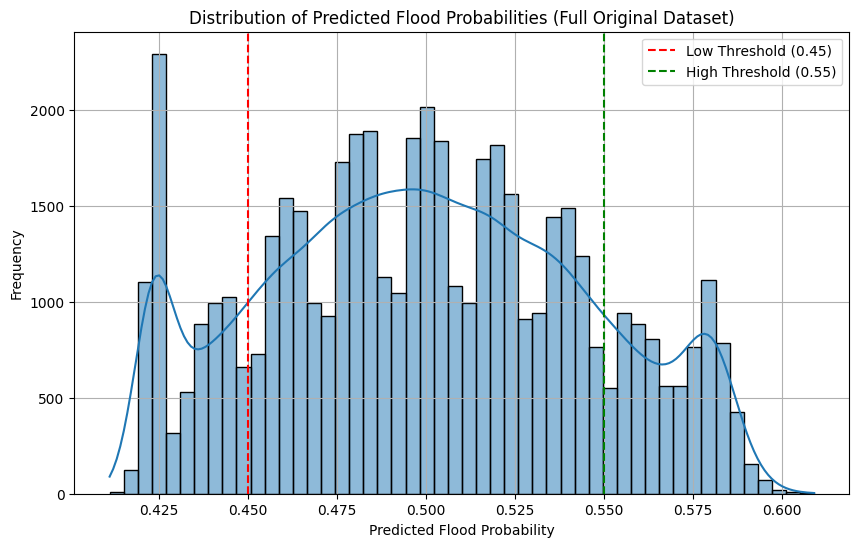

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_with_predictions' in locals() and 'Predicted_Flood_Probability' in df_with_predictions.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_with_predictions['Predicted_Flood_Probability'], bins=50, kde=True)
    plt.title('Distribution of Predicted Flood Probabilities (Full Original Dataset)')
    plt.xlabel('Predicted Flood Probability')
    plt.ylabel('Frequency')
    plt.axvline(0.45, color='red', linestyle='--', label='Low Threshold (0.45)')
    plt.axvline(0.55, color='green', linestyle='--', label='High Threshold (0.55)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("df_with_predictions DataFrame or 'Predicted_Flood_Probability' column not found.")
    print("Please ensure Cell 3 from the previous response ran correctly and populated df_with_predictions.")

LSTM+MLP

In [88]:
import numpy as np
import pandas as pd

# --- Load pre-extracted LSTM features and labels ---
lstm_features_filepath = 'extracted_lstm_features.npy'
lstm_labels_filepath = 'extracted_lstm_labels.npy'

try:
    print(f"Attempting to load: {lstm_features_filepath}")
    X_lstm = np.load(lstm_features_filepath, allow_pickle=True)
    print(f"Successfully loaded: {lstm_features_filepath}")

    print(f"Attempting to load: {lstm_labels_filepath}")
    y_lstm_image_labels = np.load(lstm_labels_filepath, allow_pickle=True)
    print(f"Successfully loaded: {lstm_labels_filepath}")

except FileNotFoundError as e:
    print(f"Error loading LSTM .npy files: {e}")
    print(f"Please ensure '{lstm_features_filepath}' and '{lstm_labels_filepath}' are in the correct location.")
    print("INFO: Creating DUMMY LSTM data as files were not found. REPLACE THIS.")
    num_lstm_samples_dummy = 10000
    num_lstm_feature_dim_dummy = 128 # Example
    X_lstm = np.random.rand(num_lstm_samples_dummy, num_lstm_feature_dim_dummy)
    y_lstm_image_labels = np.random.randint(0, 2, num_lstm_samples_dummy)
except ValueError as ve:
    print(f"ValueError during loading (even with allow_pickle=True): {ve}")
    print("The .npy file might be corrupted or in an unexpected format.")


print("\n--- LSTM Data Loaded (or Dummies Created) ---")
print(f"Shape of X_lstm (image features): {X_lstm.shape if 'X_lstm' in locals() else 'X_lstm not loaded'}")
print(f"Shape of y_lstm_image_labels: {y_lstm_image_labels.shape if 'y_lstm_image_labels' in locals() else 'y_lstm_image_labels not loaded'}")

if 'y_lstm_image_labels' in locals():
    unique_lstm_labels, counts_lstm_labels = np.unique(y_lstm_image_labels, return_counts=True)
    print("\nValue counts for LSTM image labels (y_lstm_image_labels):")
    if len(unique_lstm_labels) > 0:
        for label, count in zip(unique_lstm_labels, counts_lstm_labels):
            print(f"Image Label {label}: {count} instances")
    else:
        print("No labels found or y_lstm_image_labels is empty.")

    # Separate LSTM features based on their image labels
    if 'X_lstm' in locals() and X_lstm.shape[0] == y_lstm_image_labels.shape[0]: # Ensure shapes match before indexing
        X_lstm_flood_images = X_lstm[y_lstm_image_labels == 1]
        X_lstm_non_flood_images = X_lstm[y_lstm_image_labels == 0]

        print(f"\nNumber of LSTM features from FLOOD images: {X_lstm_flood_images.shape[0]}")
        print(f"Number of LSTM features from NON-FLOOD images: {X_lstm_non_flood_images.shape[0]}")
    else:
        print("\nCould not separate LSTM features by label due to missing data or shape mismatch.")
        X_lstm_flood_images = np.array([])
        X_lstm_non_flood_images = np.array([])

else:
    print("\ny_lstm_image_labels not loaded, cannot process further LSTM data steps here.")
    X_lstm_flood_images = np.array([])
    X_lstm_non_flood_images = np.array([])

Attempting to load: extracted_lstm_features.npy
Successfully loaded: extracted_lstm_features.npy
Attempting to load: extracted_lstm_labels.npy
Successfully loaded: extracted_lstm_labels.npy

--- LSTM Data Loaded (or Dummies Created) ---
Shape of X_lstm (image features): (37,)
Shape of y_lstm_image_labels: (37,)

Value counts for LSTM image labels (y_lstm_image_labels):
Image Label 0: 26 instances
Image Label 1: 11 instances

Number of LSTM features from FLOOD images: 11
Number of LSTM features from NON-FLOOD images: 26


In [89]:
if 'X_new_labeled_features' not in locals() or 'y_new_binary_labels' not in locals():
    print("INFO: X_new_labeled_features or y_new_binary_labels not found. Creating DUMMIES.")
    num_tabular_samples_dummy = 14939
    num_tabular_features_dummy = 20
    X_new_labeled_features = pd.DataFrame(np.random.rand(num_tabular_samples_dummy, num_tabular_features_dummy),
                                         columns=[f'tab_feat_{i}' for i in range(num_tabular_features_dummy)])
    # Create a balanced dummy y_new_binary_labels
    dummy_labels = np.zeros(num_tabular_samples_dummy, dtype=int)
    dummy_labels[:7500] = 1 # Roughly balanced
    np.random.shuffle(dummy_labels)
    y_new_binary_labels = pd.Series(dummy_labels)
    print("       You MUST use your actual X_new_labeled_features and y_new_binary_labels.")


# Separate tabular features based on their MLP-derived binary labels
X_tabular_mlp_flood_conditions = X_new_labeled_features[y_new_binary_labels == 1]
X_tabular_mlp_non_flood_conditions = X_new_labeled_features[y_new_binary_labels == 0]

print("\n--- Tabular Data (Derived from MLP predictions) ---")
print(f"Number of tabular feature sets for MLP-identified FLOOD conditions: {X_tabular_mlp_flood_conditions.shape[0]}")
print(f"Number of tabular feature sets for MLP-identified NON-FLOOD conditions: {X_tabular_mlp_non_flood_conditions.shape[0]}")


--- Tabular Data (Derived from MLP predictions) ---
Number of tabular feature sets for MLP-identified FLOOD conditions: 7500
Number of tabular feature sets for MLP-identified NON-FLOOD conditions: 7439


In [90]:
import numpy as np

if 'X_lstm' not in locals():
    print("X_lstm is not loaded. Please load it first (with allow_pickle=True).")
    print("INFO: Creating a DUMMY X_lstm that mimics your described structure.")
    list_of_arrays = []
    list_of_arrays.append(np.random.rand(4, 2048))
    list_of_arrays.append(np.random.rand(3, 2048))
    list_of_arrays.append(np.random.rand(5, 2048))
    for _ in range(34):
        steps = np.random.randint(2, 6)
        list_of_arrays.append(np.random.rand(steps, 2048))
    X_lstm = np.array(list_of_arrays, dtype=object)
    print(f"Dummy X_lstm created. Shape: {X_lstm.shape}, dtype: {X_lstm.dtype}")
    if len(X_lstm) > 0:
        print(f"Shape of first element in dummy X_lstm: {X_lstm[0].shape}")


# --- Mean Pooling over the 'steps' dimension ---
if X_lstm.dtype == 'object' and len(X_lstm) > 0:
    X_lstm_fixed_list_mean = []
    successful_conversions = 0
    expected_feature_dim = -1

    all_elements_valid = True
    for i, arr in enumerate(X_lstm):
        if isinstance(arr, np.ndarray) and arr.ndim == 2:
            if expected_feature_dim == -1:
                expected_feature_dim = arr.shape[1]
            elif arr.shape[1] != expected_feature_dim:
                print(f"Error: Element {i} has an inconsistent feature dimension: {arr.shape[1]}. Expected {expected_feature_dim}.")
                all_elements_valid = False
                break
        else:
            print(f"Error: Element {i} is not a 2D NumPy array. Type: {type(arr)}, Ndim: {arr.ndim if hasattr(arr, 'ndim') else 'N/A'}")
            all_elements_valid = False
            break

    if all_elements_valid and expected_feature_dim != -1:
        for i, arr in enumerate(X_lstm):
            mean_pooled_vector = np.mean(arr, axis=0)
            if mean_pooled_vector.shape == (expected_feature_dim,):
                X_lstm_fixed_list_mean.append(mean_pooled_vector)
                successful_conversions += 1
            else:
                print(f"Warning: Mean pooling for element {i} resulted in unexpected shape {mean_pooled_vector.shape}. Expected ({expected_feature_dim},)")

        if successful_conversions == len(X_lstm):
            X_lstm_processed = np.array(X_lstm_fixed_list_mean)
            print(f"\nSuccessfully converted X_lstm using MEAN POOLING.")
            print(f"Shape of processed X_lstm (X_lstm_processed): {X_lstm_processed.shape}")
        else:
            print(f"\nMean pooling failed for some elements. Processed {successful_conversions}/{len(X_lstm)}.")
            X_lstm_processed = None
    else:
        if not all_elements_valid:
            print("\nCannot proceed with mean pooling due to invalid elements in X_lstm.")
        X_lstm_processed = None

else:
    print("X_lstm is not in the expected format (1D array of objects) or is empty.")
    X_lstm_processed = None
    if 'X_lstm' in locals() and X_lstm.ndim == 2:
        print("X_lstm appears to be already 2D. Using it as is.")
        X_lstm_processed = X_lstm

# --- Assign the chosen processed features to X_lstm for next steps ---
if 'X_lstm_processed' in locals() and X_lstm_processed is not None:
    X_lstm = X_lstm_processed # This reassigns X_lstm to be the 2D array
    print(f"\n`X_lstm` has been updated to the processed 2D array with shape: {X_lstm.shape}")
elif 'X_lstm' in locals() and X_lstm.ndim == 2:
    print(f"\n`X_lstm` was already 2D with shape: {X_lstm.shape}. No processing applied in this step.")
else:
    print("\nWARNING: `X_lstm` could not be converted to a 2D array. Subsequent steps will likely fail or use dummy data.")
    num_samples_lstm = 37
    num_features_lstm_dummy = 2048
    X_lstm = np.random.rand(num_samples_lstm, num_features_lstm_dummy)
    print(f"INFO: Created DUMMY X_lstm with shape {X_lstm.shape} as processing failed.")


Successfully converted X_lstm using MEAN POOLING.
Shape of processed X_lstm (X_lstm_processed): (37, 2048)

`X_lstm` has been updated to the processed 2D array with shape: (37, 2048)


In [91]:
if 'X_lstm' in locals() and 'y_lstm_image_labels' in locals() and len(X_lstm.shape) == 2:
    X_lstm_flood_images = X_lstm[y_lstm_image_labels == 1]
    X_lstm_non_flood_images = X_lstm[y_lstm_image_labels == 0]
    print(f"Corrected shape of X_lstm_flood_images: {X_lstm_flood_images.shape}")
    print(f"Corrected shape of X_lstm_non_flood_images: {X_lstm_non_flood_images.shape}")
else:
    print("Error: X_lstm is not a 2D array or y_lstm_image_labels is missing. Please resolve Step 1.")
    if 'X_lstm_flood_images' not in locals() or X_lstm_flood_images.ndim != 2:
        X_lstm_flood_images = np.random.rand(11, 128)
        print(f"INFO: Using DUMMY X_lstm_flood_images: {X_lstm_flood_images.shape}")
    if 'X_lstm_non_flood_images' not in locals() or X_lstm_non_flood_images.ndim != 2:
        X_lstm_non_flood_images = np.random.rand(26, 128)
        print(f"INFO: Using DUMMY X_lstm_non_flood_images: {X_lstm_non_flood_images.shape}")


Corrected shape of X_lstm_flood_images: (11, 2048)
Corrected shape of X_lstm_non_flood_images: (26, 2048)


In [92]:
if 'X_lstm_flood_images' not in locals() or X_lstm_flood_images.shape != (11, 2048):
    print("INFO: X_lstm_flood_images not found or has incorrect shape. Creating DUMMY.")
    X_lstm_flood_images = np.random.rand(11, 2048)
if 'X_lstm_non_flood_images' not in locals() or X_lstm_non_flood_images.shape != (26, 2048):
    print("INFO: X_lstm_non_flood_images not found or has incorrect shape. Creating DUMMY.")
    X_lstm_non_flood_images = np.random.rand(26, 2048)
if 'y_lstm_image_labels' not in locals() or len(y_lstm_image_labels) != 37:
     print("INFO: y_lstm_image_labels not found or has incorrect shape. Creating DUMMY.")
     y_lstm_image_labels = np.concatenate([np.ones(11), np.zeros(26)])
     np.random.shuffle(y_lstm_image_labels)


if 'X_tabular_mlp_flood_conditions' not in locals() or X_tabular_mlp_flood_conditions.shape[0] != 7500:
    print("INFO: X_tabular_mlp_flood_conditions not found or has incorrect shape. Creating DUMMY.")
    X_tabular_mlp_flood_conditions = pd.DataFrame(np.random.rand(7500, 20), columns=[f'tab_feat_{i}' for i in range(20)])
if 'X_tabular_mlp_non_flood_conditions' not in locals() or X_tabular_mlp_non_flood_conditions.shape[0] != 7439:
    print("INFO: X_tabular_mlp_non_flood_conditions not found or has incorrect shape. Creating DUMMY.")
    X_tabular_mlp_non_flood_conditions = pd.DataFrame(np.random.rand(7439, 20), columns=[f'tab_feat_{i}' for i in range(20)])


if (X_lstm_flood_images.ndim == 2 and X_lstm_flood_images.shape[0] > 0 and
    X_lstm_non_flood_images.ndim == 2 and X_lstm_non_flood_images.shape[0] > 0 and
    not X_tabular_mlp_flood_conditions.empty and not X_tabular_mlp_non_flood_conditions.empty):

    num_lstm_flood_samples = X_lstm_flood_images.shape[0]
    num_lstm_non_flood_samples = X_lstm_non_flood_images.shape[0]

    sampled_tabular_flood_df = X_tabular_mlp_flood_conditions.sample(
        n=num_lstm_flood_samples, replace=True, random_state=42
    )
    sampled_tabular_flood_np = sampled_tabular_flood_df.to_numpy()

    sampled_tabular_non_flood_df = X_tabular_mlp_non_flood_conditions.sample(
        n=num_lstm_non_flood_samples, replace=True, random_state=42
    )
    sampled_tabular_non_flood_np = sampled_tabular_non_flood_df.to_numpy()

    # Concatenate LSTM features with sampled tabular features for each class
    combined_flood_features = np.concatenate((X_lstm_flood_images, sampled_tabular_flood_np), axis=1)
    combined_non_flood_features = np.concatenate((X_lstm_non_flood_images, sampled_tabular_non_flood_np), axis=1)

    # Combine flood and non-flood samples back together
    X_combined_final = np.concatenate((combined_flood_features, combined_non_flood_features), axis=0)

    # Create corresponding labels for this combined dataset
    # These labels come from the IMAGE events (y_lstm_image_labels)
    # It's crucial to maintain the correct order corresponding to X_lstm_flood_images then X_lstm_non_flood_images
    y_combined_final_labels = np.concatenate(
        (np.ones(num_lstm_flood_samples, dtype=int), np.zeros(num_lstm_non_flood_samples, dtype=int))
    )

    # Shuffle the combined dataset to mix flood and non-flood samples for training
    from sklearn.utils import shuffle
    X_combined_final, y_combined_final_labels = shuffle(X_combined_final, y_combined_final_labels, random_state=42)

    print("\n--- Combined Dataset Created (LSTM + Sampled Tabular by Class) ---")
    print(f"Shape of X_combined_final: {X_combined_final.shape}") # Should be (37, 2048 + 20)
    print(f"Shape of y_combined_final_labels: {y_combined_final_labels.shape}") # Should be (37,)
    # print(f"Sample of X_combined_final (first row, first 10 features): {X_combined_final[0, :min(10, X_combined_final.shape[1])]}")
    print(f"Value counts for y_combined_final_labels: {pd.Series(y_combined_final_labels).value_counts()}")

else:
    print("\nCould not create combined dataset. Please check the shapes and availability of prerequisite data from Cell 1 & 2 logic.")
    X_combined_final = np.random.rand(37, 2048 + 20)
    y_combined_final_labels = np.random.randint(0,2,37)
    print(f"INFO: Using DUMMY X_combined_final (shape {X_combined_final.shape}) and y_combined_final_labels.")


--- Combined Dataset Created (LSTM + Sampled Tabular by Class) ---
Shape of X_combined_final: (37, 2068)
Shape of y_combined_final_labels: (37,)
Value counts for y_combined_final_labels: 0    26
1    11
Name: count, dtype: int64


In [93]:
from sklearn.model_selection import train_test_split

if X_combined_final.shape[0] == 37:
    test_set_size = max(5, int(0.2 * len(y_combined_final_labels)))

    X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(
        X_combined_final,
        y_combined_final_labels,
        test_size=test_set_size,
        random_state=42,
        stratify=y_combined_final_labels
    )

    print(f"\n--- Combined Data Split for Quantile Regression Experiment ---")
    print(f"Shape of X_train_comb: {X_train_comb.shape}, y_train_comb: {y_train_comb.shape}")
    print(f"Shape of X_test_comb:  {X_test_comb.shape}, y_test_comb:  {y_test_comb.shape}")
    print(f"y_train_comb distribution: {pd.Series(y_train_comb).value_counts(normalize=True)}")
    print(f"y_test_comb distribution: {pd.Series(y_test_comb).value_counts(normalize=True)}")
else:
    print("X_combined_final does not have 37 samples as expected. Skipping split.")
    dummy_features_count = (X_combined_final.shape[1] if X_combined_final.ndim == 2 and X_combined_final.shape[0] > 0
                            else 2048 + 20)
    X_train_comb = np.random.rand(30, dummy_features_count)
    y_train_comb = np.random.randint(0,2,30)
    X_test_comb = np.random.rand(7, dummy_features_count)
    y_test_comb = np.random.randint(0,2,7)
    print(f"INFO: Using DUMMY data splits. X_train_comb: {X_train_comb.shape}, X_test_comb: {X_test_comb.shape}")


--- Combined Data Split for Quantile Regression Experiment ---
Shape of X_train_comb: (30, 2068), y_train_comb: (30,)
Shape of X_test_comb:  (7, 2068), y_test_comb:  (7,)
y_train_comb distribution: 0    0.7
1    0.3
Name: proportion, dtype: float64
y_test_comb distribution: 0    0.714286
1    0.285714
Name: proportion, dtype: float64


In [94]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

QUANTILES = [0.05, 0.50, 0.95]

def quantile_regression_loss(quantiles_list):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        e = y_true - y_pred
        q_losses_terms = []
        for i, q_val in enumerate(quantiles_list):
            q_loss_term = tf.maximum(q_val * e[:, i], (q_val - 1) * e[:, i])
            q_losses_terms.append(q_loss_term)
        stacked_q_losses = tf.stack(q_losses_terms, axis=1)
        return tf.reduce_mean(tf.reduce_sum(stacked_q_losses, axis=1)) # Sum losses over quantiles for a sample
    return loss


if 'X_train_comb' in locals() and X_train_comb.shape[0] > 0 :
    input_dim_final_model = X_train_comb.shape[1]
    output_dim_final_model = len(QUANTILES)

    final_qr_model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=(input_dim_final_model,),
                     kernel_regularizer=keras.regularizers.l2(0.01)), # Add regularization
        layers.Dropout(0.5), # Heavy dropout
        layers.Dense(16, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(output_dim_final_model) # Linear activation for quantile outputs
    ])

    final_qr_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001), # Might need very small LR
        loss=quantile_regression_loss(QUANTILES)
    )
    final_qr_model.summary()

    y_train_comb_reshaped = np.expand_dims(y_train_comb, axis=-1)

    print(f"\n--- Training Experimental Quantile Regression Model on {X_train_comb.shape[0]} samples ---")
    print("WARNING: Training on a very small dataset. Results will likely be unstable and overfit.")

    history_final_qr = final_qr_model.fit(
        X_train_comb,
        y_train_comb_reshaped,
        epochs=100,
        batch_size=2,
        validation_split=0.2,
        verbose=1,
        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min')]
    )

    # --- Evaluate the Quantile Regression Model ---
    if X_test_comb.shape[0] > 0:
        print("\n--- Evaluating Experimental Quantile Regression Model on Test Set ---")
        y_test_comb_reshaped = np.expand_dims(y_test_comb, axis=-1)
        test_loss_qr = final_qr_model.evaluate(X_test_comb, y_test_comb_reshaped, verbose=0)
        print(f"Test Loss (Pinball Loss for Quantiles {QUANTILES}): {test_loss_qr:.4f}")

        predicted_quantiles_test = final_qr_model.predict(X_test_comb)

        print(f"\nExample Predictions (Lower Q, Median Q, Upper Q) vs Actual Binary Label (first {len(y_test_comb)} test samples):")
        for i in range(len(y_test_comb)):
            print(f"Sample {i+1}: "
                  f"Pred_Q({QUANTILES[0]})={predicted_quantiles_test[i,0]:.4f}, "
                  f"Pred_Q({QUANTILES[1]})={predicted_quantiles_test[i,1]:.4f}, "
                  f"Pred_Q({QUANTILES[2]})={predicted_quantiles_test[i,2]:.4f}. "
                  f"Actual Label={y_test_comb[i]}")
    else:
        print("\nTest set is empty, skipping evaluation.")
else:
    print("\nCombined training data (X_train_comb) not available or empty. Cannot proceed with final model training.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 32)             │        66,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,787 (260.89 KB)

 Trainable params: 66,787 (260.89 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Experimental Quantile Regression Model on 30 samples ---
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.2112 - val_loss: 1.1147
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1612 - val_loss: 0.8394
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6543 - val_loss: 0.7386
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7166 - val_loss: 0.6853
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7418 - val_loss: 0.6550
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5189 - val_loss: 0.6135
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6844 - val_loss: 0.5906
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5335 - val_loss: 0.5548
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5045 - val_loss: 0.5371
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4713 - val_loss: 0.5033
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3632 - val_l

--- Classification Metrics based on Median Quantile (Q50 > 0.5) ---
Test Set Size: 7
Accuracy: 0.7143
Precision (for class 1): 0.0000
Recall (for class 1): 0.0000
F1-score (for class 1): 0.0000


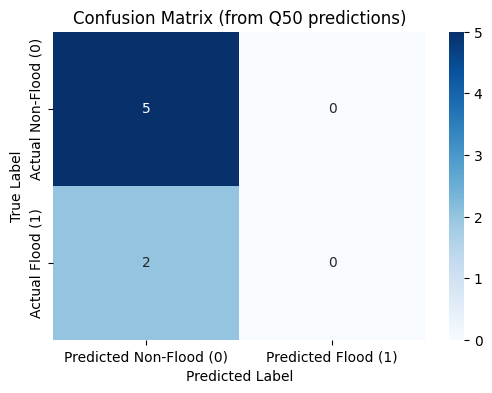

In [95]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

if 'predicted_quantiles_test' not in locals() or 'y_test_comb' not in locals():
    print("INFO: `predicted_quantiles_test` or `y_test_comb` not found. Using DUMMY data for demonstration.")
    predicted_quantiles_test = np.array([
        [-0.0353, 0.2316, 0.3861], # Actual 0
        [-0.1870, 0.4377, 0.5895], # Actual 1
        [-0.1107, 0.2468, 0.4752], # Actual 0
        [-0.1078, 0.1768, 0.5104], # Actual 0
        [-0.2318, -0.0813, 0.4424],# Actual 0
        [-0.2458, -0.0186, 0.6032],# Actual 0
        [-0.1370, 0.4921, 0.6368]  # Actual 1
    ])
    y_test_comb = np.array([0, 1, 0, 0, 0, 0, 1])
    QUANTILES = [0.05, 0.50, 0.95]

median_predictions = predicted_quantiles_test[:, QUANTILES.index(0.50)]

# Convert median predictions to binary class labels (threshold at 0.5)
binary_predictions_from_median = (median_predictions > 0.5).astype(int)

print("--- Classification Metrics based on Median Quantile (Q50 > 0.5) ---")
if len(y_test_comb) > 0:
    accuracy = accuracy_score(y_test_comb, binary_predictions_from_median)
    precision = precision_score(y_test_comb, binary_predictions_from_median, zero_division=0)
    recall = recall_score(y_test_comb, binary_predictions_from_median, zero_division=0)
    f1 = f1_score(y_test_comb, binary_predictions_from_median, zero_division=0)

    print(f"Test Set Size: {len(y_test_comb)}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (for class 1): {precision:.4f}")
    print(f"Recall (for class 1): {recall:.4f}")
    print(f"F1-score (for class 1): {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test_comb, binary_predictions_from_median)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Non-Flood (0)', 'Predicted Flood (1)'],
                yticklabels=['Actual Non-Flood (0)', 'Actual Flood (1)'])
    plt.title('Confusion Matrix (from Q50 predictions)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("Test set is empty. Cannot calculate classification metrics.")

In [96]:
print("\n--- R-squared based on Median Quantile (Q50) ---")
if len(y_test_comb) > 0:
    # Ensure y_test_comb and median_predictions are 1D for r2_score
    r_squared_q50 = r2_score(y_test_comb.ravel(), median_predictions.ravel())
    print(f"R-squared (Q50 vs Actual Binary Labels): {r_squared_q50:.4f}")
else:
    print("Test set is empty. Cannot calculate R-squared.")


--- R-squared based on Median Quantile (Q50) ---
R-squared (Q50 vs Actual Binary Labels): 0.1196



--- Prediction Interval Performance (90% Interval) ---
Coverage of 90% Prediction Interval: 85.71%
(6 out of 7 actual values fell within their predicted 90% interval)


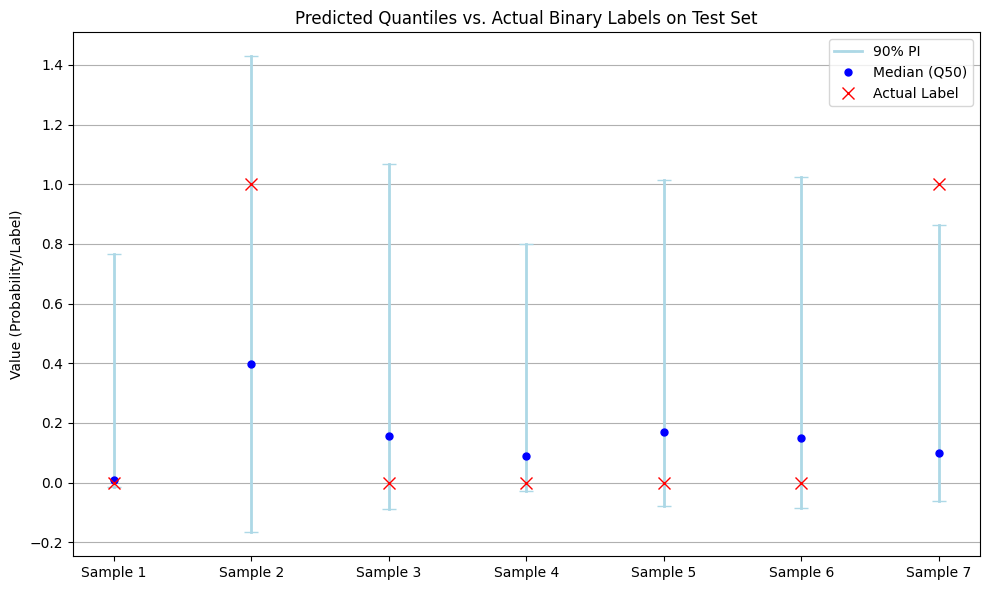

In [97]:
print("\n--- Prediction Interval Performance (90% Interval) ---")
if len(y_test_comb) > 0:
    lower_bounds = predicted_quantiles_test[:, QUANTILES.index(0.05)]
    upper_bounds = predicted_quantiles_test[:, QUANTILES.index(0.95)]

    covered_count = 0
    for i in range(len(y_test_comb)):
        actual = y_test_comb[i]
        lower = lower_bounds[i]
        upper = upper_bounds[i]
        if actual >= lower and actual <= upper:
            covered_count += 1

    coverage_percentage = (covered_count / len(y_test_comb)) * 100
    print(f"Coverage of 90% Prediction Interval: {coverage_percentage:.2f}%")
    print(f"({covered_count} out of {len(y_test_comb)} actual values fell within their predicted 90% interval)")

    # Visualize the intervals and actuals
    plt.figure(figsize=(10, 6))
    for i in range(len(y_test_comb)):
        plt.plot([i, i], [lower_bounds[i], upper_bounds[i]], marker='_', markersize=10, color='lightblue', linewidth=2, label='90% PI' if i == 0 else "")
        plt.plot(i, median_predictions[i], 'o', color='blue', markersize=5, label='Median (Q50)' if i == 0 else "")
        plt.plot(i, y_test_comb[i], 'x', color='red', markersize=8, label='Actual Label' if i == 0 else "")

    plt.xticks(ticks=np.arange(len(y_test_comb)), labels=[f"Sample {j+1}" for j in range(len(y_test_comb))])
    plt.ylabel("Value (Probability/Label)")
    plt.title("Predicted Quantiles vs. Actual Binary Labels on Test Set")
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

else:
    print("Test set is empty. Cannot visualize interval performance.")



--- Training MLP Classifier on Combined Features ---
Training samples: 30, Test samples: 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_58 (Dense)                │ (None, 32)             │        66,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,753 (260.75 KB)

 Trainable params: 66,753 (260.75 KB)

 Non-trainable params: 0 (0.00 B)

Using class weights for MLP classifier: {0: np.float64(0.7142857142857142), 1: np.float64(1.6666666666666665)}

Training MLP classifier...
MLP Classifier training complete.

--- MLP Classifier Evaluation on Test Set ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.33      0.50      0.40         2

    accuracy                           0.57         7
   macro avg       0.54      0.55      0.53         7
weighted avg       0.63      0.57      0.59         7

AUC Score: 0.7000


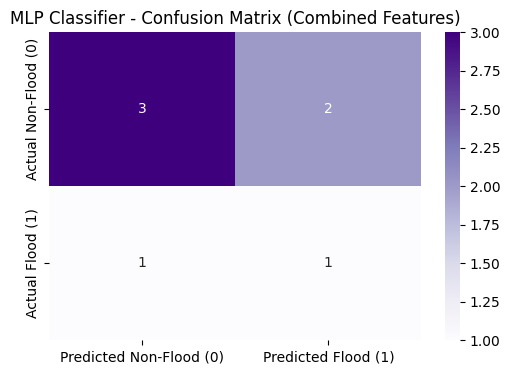

In [104]:
# Cell: MLP Classifier on Combined Features
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

if 'X_combined_final' not in locals() or 'y_combined_final_labels' not in locals() or X_combined_final.shape[0] != 37:
    print("INFO: Using DUMMY X_combined_final and y_combined_final_labels for MLP Classifier.")
    X_combined_final = np.random.rand(37, 2068)
    y_combined_final_labels = np.concatenate([np.ones(11), np.zeros(26)])
    np.random.shuffle(y_combined_final_labels)

if X_combined_final.shape[0] < 10:
    print("Combined dataset is too small to proceed.")
else:

    test_set_size_clf = max(5, int(0.2 * len(y_combined_final_labels)))
    if X_combined_final.shape[0] - test_set_size_clf < 5:
         test_set_size_clf = max(1, X_combined_final.shape[0] - 5) if X_combined_final.shape[0] > 5 else 1

    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_combined_final, y_combined_final_labels,
        test_size=test_set_size_clf, random_state=42, stratify=y_combined_final_labels
    )

    scaler_comb = StandardScaler()
    X_train_scaled_c = scaler_comb.fit_transform(X_train_c)
    X_test_scaled_c = scaler_comb.transform(X_test_c) # Use transform only on test

    print(f"\n--- Training MLP Classifier on Combined Features ---")
    print(f"Training samples: {X_train_scaled_c.shape[0]}, Test samples: {X_test_scaled_c.shape[0]}")

    input_dim_clf = X_train_scaled_c.shape[1]
    clf_mlp_model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=(input_dim_clf,),
                     kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    clf_mlp_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall'), keras.metrics.AUC(name='auc')]
    )
    clf_mlp_model.summary()

    counts_train_c = np.bincount(y_train_c.astype(int))
    class_weight_dict_c = None
    if len(counts_train_c) == 2 and counts_train_c[0] > 0 and counts_train_c[1] > 0:
        weight_for_0_c = (1 / counts_train_c[0]) * (len(y_train_c)) / 2.0
        weight_for_1_c = (1 / counts_train_c[1]) * (len(y_train_c)) / 2.0
        class_weight_dict_c = {0: weight_for_0_c, 1: weight_for_1_c}
        print(f"Using class weights for MLP classifier: {class_weight_dict_c}")

    print("\nTraining MLP classifier...")
    history_clf_mlp = clf_mlp_model.fit(
        X_train_scaled_c, y_train_c,
        epochs=200,
        batch_size=4,
        validation_split=0.2,
        class_weight=class_weight_dict_c,
        # callbacks=[keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=30, restore_best_weights=True, verbose=1)], # Monitor recall
        verbose=0
    )
    print("MLP Classifier training complete.")

    # Evaluate MLP Classifier
    print("\n--- MLP Classifier Evaluation on Test Set ---")
    if X_test_scaled_c.shape[0] > 0:
        y_pred_proba_mlp = clf_mlp_model.predict(X_test_scaled_c).ravel()
        y_pred_binary_mlp = (y_pred_proba_mlp > 0.55).astype(int)

        print(classification_report(y_test_c, y_pred_binary_mlp, zero_division=0))
        try:
            print(f"AUC Score: {roc_auc_score(y_test_c, y_pred_proba_mlp):.4f}")
        except ValueError as e:
            print(f"Could not calculate AUC for MLP classifier: {e}")

        cm_mlp = confusion_matrix(y_test_c, y_pred_binary_mlp)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Purples',
                    xticklabels=['Predicted Non-Flood (0)', 'Predicted Flood (1)'],
                    yticklabels=['Actual Non-Flood (0)', 'Actual Flood (1)'])
        plt.title('MLP Classifier - Confusion Matrix (Combined Features)')
        plt.show()
    else:
        print("Test set is empty, skipping evaluation.")


--- Training Logistic Regression on Combined Features ---
Logistic Regression training complete.

--- Logistic Regression Evaluation on Test Set ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

AUC Score: 1.0000


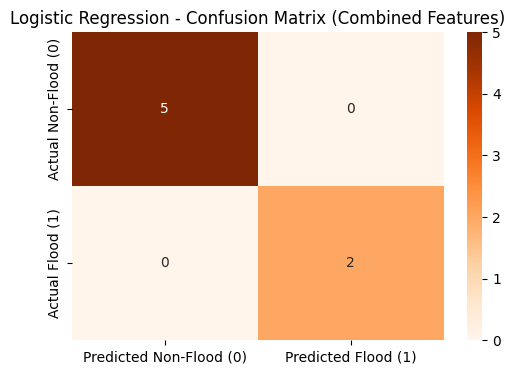

In [99]:
# Cell: Logistic Regression on Combined Features
from sklearn.linear_model import LogisticRegression # Import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

if 'X_train_scaled_c' in locals() and X_train_scaled_c.shape[0] > 0:
    print("\n--- Training Logistic Regression on Combined Features ---")
    log_reg_model = LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced', # Handles imbalance in the training set
        solver='liblinear',      # Good for smaller datasets and L1/L2 penalties
        penalty='l1'             # L1 regularization for feature selection/sparsity
    )
    log_reg_model.fit(X_train_scaled_c, y_train_c)
    print("Logistic Regression training complete.")

    # Evaluate Logistic Regression
    if X_test_scaled_c.shape[0] > 0:
        print("\n--- Logistic Regression Evaluation on Test Set ---")
        y_pred_proba_lr = log_reg_model.predict_proba(X_test_scaled_c)[:, 1]
        y_pred_binary_lr = log_reg_model.predict(X_test_scaled_c)

        print(classification_report(y_test_c, y_pred_binary_lr, zero_division=0))
        try:
            print(f"AUC Score: {roc_auc_score(y_test_c, y_pred_proba_lr):.4f}")
        except ValueError as e:
            print(f"Could not calculate AUC for Logistic Regression: {e}")

        cm_lr = confusion_matrix(y_test_c, y_pred_binary_lr)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges',
                    xticklabels=['Predicted Non-Flood (0)', 'Predicted Flood (1)'],
                    yticklabels=['Actual Non-Flood (0)', 'Actual Flood (1)'])
        plt.title('Logistic Regression - Confusion Matrix (Combined Features)')
        plt.show()
    else:
        print("Test set empty, skipping Logistic Regression evaluation.")
else:
    print("\nTraining data for combined features not available for Logistic Regression.")